In [1]:
pip install -q opencv-python==4.10.0.84 scikit-image==0.24.0

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# 1. 환경 설정 및 라이브러리 로드

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.patches as patches
import dlib
from tensorflow.keras.models import load_model # 모델 로드에 필수



/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [4]:
!pip install mediapipe gradio dlib opencv-python numpy matplotlib
# dlib shape predictor가 없다면 다운로드 (이미 있다면 주석 처리)
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2025-12-05 06:46:49--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-12-05 06:46:49--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[===================>]  61.07M  45.0MB/s    in 1.4s    

2025-12-05 06:46:51 (45.0 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.1’ saved [64040097/64040097]



In [5]:
# 상수 설정
IMAGE_SIZE = 224
BATCH_SIZE = 16
DATA_DIR = '/content/drive/MyDrive/영상처리/data/'
MODEL_SAVE_PATH = '/content/drive/MyDrive/영상처리/personal_color_mobilenetv2_model.h5'
TEST_IMAGE_PATH = '/content/drive/MyDrive/영상처리/data/t2.jpg'
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"

In [6]:


# 3. 데이터 로드 및 분할 (Deep Learning 전처리)

# ImageDataGenerator를 사용하여 데이터 증강 및 표준화
train_datagen = ImageDataGenerator(
    rescale=1./255, # 픽셀 값 정규화 (0~1)
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 훈련 데이터의 20%를 검증에 사용
)

# 학습 데이터 생성기
# DATA_DIR 내부의 'warm'과 'cool' 폴더를 자동으로 클래스로 인식합니다.
try:
    train_generator = train_datagen.flow_from_directory(
        DATA_DIR,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical', # 웜톤, 쿨톤 2가지 클래스
        subset='training'
    )

    # 검증 데이터 생성기
    validation_generator = train_datagen.flow_from_directory(
        DATA_DIR,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    # 클래스 이름 확인
    class_names = list(train_generator.class_indices.keys())
    print(f"클래스 인덱스: {train_generator.class_indices}")

except Exception as e:
    print(f"데이터 로딩 중 오류 발생: {e}")
    print("경로와 폴더 이름(warm, cool)을 다시 한번 확인해주세요.")

# ----------------------------------------
# 4. 딥러닝 모델 정의 (전이 학습 - MobileNetV2)
# ----------------------------------------

# 데이터가 성공적으로 로드되었는지 확인 후 모델 정의 및 학습 진행
if train_generator.samples > 0:
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )

    base_model.trainable = False # 베이스 모델 가중치 고정

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(class_names), activation='softmax')(x) # 최종 출력: 2개 클래스

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    # ----------------------------------------
    # 5. 모델 학습
    # ----------------------------------------
    epochs = 20 # 테스트 목적이라면 5~10 정도로 낮춰서 빠르게 확인 가능

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        epochs=epochs
    )

    # 모델 저장
    model.save('/content/drive/MyDrive/영상처리/personal_color_mobilenetv2_model.h5')

    # ----------------------------------------
    # 6. 예측 및 영상 처리 기반 추천 (추가 기능)
    # ----------------------------------------

    # ... (예측 및 추천 함수는 이전 코드와 동일하게 적용 가능)
else:
    print("학습할 이미지가 0개입니다. 데이터셋 경로를 확인해주세요.")

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
클래스 인덱스: {'cool': 0, 'warm': 1}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,914,882 (11.12 MB)

 Trainable params: 656,898 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.4854 - loss: 1.0166 - val_accuracy: 0.6250 - val_loss: 0.6166
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5271 - loss: 0.7656 - val_accuracy: 0.6875 - val_loss: 0.6185
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6389 - loss: 0.7432 - val_accuracy: 0.5625 - val_loss: 0.6869
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5540 - loss: 0.7937 - val_accuracy: 0.4375 - val_loss: 0.8328
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4906 - loss: 0.8219 - val_accuracy: 0.5000 - val_loss: 0.7028
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6484 - loss: 0.7158 - val_accuracy: 0.5000 - val_loss: 0.7618
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6646 - loss: 0.6923 - val_accuracy: 0.5625 - val_loss: 0.7323
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6010 - loss: 0.6368 - val_accuracy: 0.5000 - val_loss: 0.6291
Epoch 9/20
5

In [7]:
# 1. 모델 로드
try:
    if 'model' not in locals() or model is None:
        model = load_model(MODEL_SAVE_PATH)
        if 'class_names' not in locals():
            class_names = ['cool', 'warm']
        print("모델 로드 성공.")
except Exception as e:
    print(f"모델 로드 실패. 학습이 완료되었거나 경로를 확인하세요: {e}")
    model = None

# 2. 프레임 전처리 및 예측 함수
def preprocess_and_predict(frame, model, class_labels, image_size=IMAGE_SIZE):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_input = cv2.resize(rgb_frame, (image_size, image_size))
    img_input = np.expand_dims(img_input / 255.0, axis=0)
    prediction = model.predict(img_input, verbose=0)[0]
    predicted_index = np.argmax(prediction)
    confidence = prediction[predicted_index] * 100
    predicted_label = class_labels[predicted_index]
    return predicted_label, confidence

# 3. 비디오 처리 파이프라인
def process_video(video_path, output_path, model, class_names):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"오류: 비디오 파일을 열 수 없습니다. 경로를 확인하세요: {video_path}")
        return
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    frame_count = 0
    predicted_color = "분석 중..."
    conf = 0.0
    print(f"--- 비디오 처리 시작: {os.path.basename(video_path)} ---")
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # 5프레임마다 예측 수행
        if frame_count % 5 == 0:
            predicted_color, conf = preprocess_and_predict(frame, model, class_names)
        text = f"Tone: {predicted_color} ({conf:.1f}%)"
        color_code = (0, 165, 255) if predicted_color.lower().find('warm') != -1 else (255, 0, 0)
        cv2.putText(frame, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color_code, 3)
        out.write(frame)
        frame_count += 1
    cap.release()
    out.release()
    print(f"비디오 처리 완료. 결과 파일 저장: {output_path}")




✨ 생얼 사진 퍼스널 컬러 진단 결과 (t2.jpg) ✨
✅ 예측된 톤: WARM (94.36% 확신)

[ 추천 색조 가이드 - 봄/가을 웜톤 (Spring/Autumn Warm) ]
- Lip: #FFB084 #E07A5F #B5653A
- Blush: #FFC899 #E0AA82 #D49C8D
- Base: #E8D3C8 #D9C9B4 #C6B4A8


/tmp/ipython-input-4277409519.py:97: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout(rect=[0, 0, 1, 0.95]) # 제목과 겹치지 않도록 조정
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48388 (\N{HANGUL SYLLABLE BOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51012 (\N{HANGUL SYLLABLE EUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50908 (\N{HANGUL SYLLABLE WEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, *

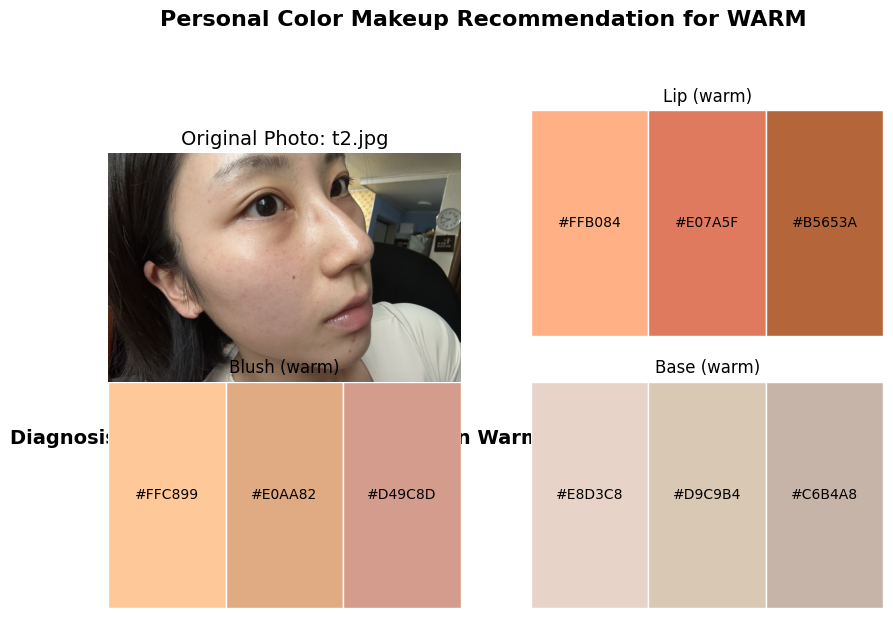

In [8]:
# ----------------------------------------
# 7.1.1 색조 추천 데이터베이스 정의 (Hex Code 사용)
# ----------------------------------------

# 쿨톤 색상 팔레트 데이터 (사용자님의 첨부 이미지 기반)
COOL_TONE_PALETTE = {
    "Lip": ["#A3366C", "#C23B6B", "#E04F7A"],
    "Blush": ["#C57BA8", "#F2A4C0", "#D689B7"],
    "Base": ["#D1C7BC", "#DDD0C5", "#E8D8CC"],
    "Tone_Description": "여름/겨울 쿨톤 (Summer/Winter Cool)"
}

# 웜톤 색상 팔레트 데이터 (예시)
WARM_TONE_PALETTE = {
    "Lip": ["#FFB084", "#E07A5F", "#B5653A"],
    "Blush": ["#FFC899", "#E0AA82", "#D49C8D"],
    "Base": ["#E8D3C8", "#D9C9B4", "#C6B4A8"],
    "Tone_Description": "봄/가을 웜톤 (Spring/Autumn Warm)"
}

def get_recommendation_data(predicted_tone):
    """예측된 톤에 따른 색상 데이터와 설명을 반환"""
    tone = predicted_tone.lower()

    if 'cool' in tone:
        return COOL_TONE_PALETTE
    elif 'warm' in tone:
        return WARM_TONE_PALETTE
    else:
        return None

# ----------------------------------------
# 7.1.2 색상 팔레트 시각화 함수
# ----------------------------------------

def visualize_palette(palette_data, image_path, predicted_label):
    """
    Matplotlib을 사용하여 추천 색상을 팔레트로 시각화합니다.
    """
    if palette_data is None:
        print("시각화할 팔레트 데이터가 없습니다.")
        return

    # 이미지 로드 (전처리된 이미지가 아닌 원본 이미지를 보여주기 위해 다시 로드)
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except:
        print("경고: 원본 이미지를 로드할 수 없어 이미지 없이 팔레트만 표시합니다.")
        img = None

    fig = plt.figure(figsize=(10, 10))

    # 1. 생얼 사진 표시 (왼쪽)
    if img is not None:
        ax1 = fig.add_subplot(2, 2, 1)
        ax1.imshow(img)
        ax1.set_title(f"Original Photo: {os.path.basename(image_path)}", fontsize=14)
        ax1.axis('off')

        # 텍스트 진단 결과 표시
        ax1.text(0.5, -0.1,
                 f"Diagnosis: {predicted_label.upper()} ({palette_data['Tone_Description']})",
                 transform=ax1.transAxes,
                 fontsize=14,
                 weight='bold',
                 ha='center')
    else:
        # 이미지를 로드할 수 없으면, 팔레트가 더 큰 공간을 차지하도록 조정 가능
        pass

    # 2. 색상 팔레트 표시 (오른쪽 및 하단)
    palette_items = list(palette_data.keys())[:-1] # 마지막 'Tone_Description' 제외

    for i, item in enumerate(palette_items):
        # 쿨톤 이미지를 기준으로 서브플롯 위치 설정 (사진 유무에 따라 위치 조정)
        ax_pos = i + 2 if img is not None else i + 1
        ax = fig.add_subplot(len(palette_items), 2 if img is not None else 1, ax_pos)

        colors = palette_data[item]
        num_colors = len(colors)

        # 실제 색상 블록 그리기
        for j, hex_color in enumerate(colors):
            # Hex to RGB (Matplotlib은 Hex 코드를 직접 지원)
            rect = patches.Rectangle((j, 0), 1, 1, facecolor=hex_color, edgecolor='white', linewidth=1)
            ax.add_patch(rect)

            # Hex 코드 텍스트 표시
            ax.text(j + 0.5, 0.5, hex_color, ha='center', va='center', fontsize=10, color='black' if sum(int(hex_color[k:k+2], 16) for k in (1, 3, 5)) > 300 else 'white')

        ax.set_xlim(0, num_colors)
        ax.set_ylim(0, 1)
        ax.set_title(f"{item} ({predicted_label.lower()})", fontsize=12)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # 제목과 겹치지 않도록 조정
    plt.suptitle(f"Personal Color Makeup Recommendation for {predicted_label.upper()}", fontsize=16, weight='bold')
    plt.show()

# ----------------------------------------
# 7.2 및 7.3 실행 부분 수정
# ----------------------------------------
# 기존 'test_single_image' 함수 내부의 4단계(색조 추천)를 아래와 같이 수정합니다.

def test_single_image(image_path, model, class_names, image_size=IMAGE_SIZE):
    if not os.path.exists(image_path):
        print(f"오류: 테스트 이미지 파일이 없습니다. 경로를 확인하세요: {image_path}")
        return

    # 1. 이미지 로드 및 전처리 (이전 코드와 동일)
    frame = cv2.imread(image_path)
    if frame is None:
        print("오류: 이미지를 로드할 수 없습니다.")
        return

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_input = cv2.resize(rgb_frame, (image_size, image_size))
    img_input = np.expand_dims(img_input / 255.0, axis=0)

    # 2. 모델 예측 (이전 코드와 동일)
    prediction = model.predict(img_input, verbose=0)[0]
    predicted_index = np.argmax(prediction)
    confidence = prediction[predicted_index] * 100
    predicted_label = class_names[predicted_index]

    # 3. 결과 출력 (텍스트)
    print("\n" + "="*50)
    print(f"✨ 생얼 사진 퍼스널 컬러 진단 결과 ({os.path.basename(image_path)}) ✨")
    print("="*50)
    print(f"✅ 예측된 톤: {predicted_label.upper()} ({confidence:.2f}% 확신)")

    # 4. 색조 추천 및 시각화 (수정된 부분)
    recommendations = get_recommendation_data(predicted_label)

    if recommendations:
        print(f"\n[ 추천 색조 가이드 - {recommendations['Tone_Description']} ]")
        # 텍스트로 Hex 코드 출력
        for item, hex_list in recommendations.items():
            if item != 'Tone_Description':
                print(f"- {item}: {' '.join(hex_list)}")

        # 5. 시각화 실행
        visualize_palette(recommendations, image_path, predicted_label)
    else:
        print("알 수 없는 톤이 예측되어 추천을 제공할 수 없습니다.")

    print("="*50)

# ----------------------------------------
# 7.3 실행 (변동 없음)
# ----------------------------------------
# 모델 로드 및 테스트 이미지 경로 설정은 기존과 동일하게 유지됩니다.
# (MODEL_SAVE_PATH 및 TEST_IMAGE_PATH 확인 필수)

try:
    if 'model' not in locals() or model is None:
        model = load_model(MODEL_SAVE_PATH)
        print("최종 모델 로드 성공.")

    # t1 사진으로 최종 진단 및 시각화 실행
    test_single_image(TEST_IMAGE_PATH, model, class_names)

except Exception as e:
    print(f"예측 단계 오류: {e}")
    print("모델 파일 경로(`MODEL_SAVE_PATH`) 또는 클래스 이름(`class_names`) 설정을 확인하세요.")

In [9]:
# Dlib 설치 (컴파일 시간이 다소 걸릴 수 있습니다)
!pip install dlib opencv-python numpy

# 랜드마크 예측 모델 다운로드
# 이 파일은 얼굴의 68개 특징점(입술, 눈 등)을 찾는데 사용됩니다.
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2025-12-05 06:50:41--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-12-05 06:50:41--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  45.4MB/s    in 1.3s    

2025-12-05 06:50:43 (45.4 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [ ]:
import dlib
import cv2
import numpy as np
import gradio as gr
import os

# ==========================================
# 1. Dlib 랜드마크 모델 설정 (가장 중요!)
# ==========================================
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"

# 파일 없으면 다운로드
if not os.path.exists(PREDICTOR_PATH):
    print("📥 랜드마크 파일 다운로드 중...")
    os.system("wget -O shape_predictor_68_face_landmarks.dat https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat")

# 여기서 detector와 predictor를 '전역 변수'로 확실하게 선언
detector = dlib.get_frontal_face_detector()
try:
    predictor = dlib.shape_predictor(PREDICTOR_PATH)
    print("✅ Predictor 로드 성공!")
except Exception as e:
    print(f"🚨 Predictor 로드 실패: {e}")

# ==========================================
# 2. 메이크업 & 분석 함수 정의
# ==========================================
def apply_lipstick_virtual(frame, landmarks, color_bgr, alpha=0.4):
    points = landmarks[48:68]
    hull = cv2.convexHull(points)
    mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [hull], 0, 255, -1)
    mask = cv2.GaussianBlur(mask, (15, 15), 0)

    color_layer = np.zeros_like(frame, dtype=np.uint8)
    color_layer[:] = color_bgr

    frame_float = frame.astype(float)
    color_layer_float = color_layer.astype(float)
    mask_float = mask.astype(float) / 255.0
    mask_3ch = cv2.merge([mask_float, mask_float, mask_float])

    output = frame_float * (1.0 - alpha * mask_3ch) + color_layer_float * (alpha * mask_3ch)
    return output.astype(np.uint8)

def apply_eyebrow_tint(frame, landmarks, color_bgr, alpha=0.3):
    result = frame.astype(float)
    color_layer = np.zeros_like(frame, dtype=np.uint8)
    color_layer[:] = color_bgr
    color_layer = color_layer.astype(float)
    mask_total = np.zeros(frame.shape[:2], dtype=np.float32)

    for idx_range in [(17, 22), (22, 27)]:
        points = landmarks[idx_range[0]:idx_range[1]]
        hull = cv2.convexHull(points)
        mask = np.zeros(frame.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [hull], 0, 255, -1)
        mask = cv2.GaussianBlur(mask, (11, 11), 0)
        mask_float = mask.astype(float) / 255.0
        mask_total = np.maximum(mask_total, mask_float)

    mask_3ch = cv2.merge([mask_total, mask_total, mask_total])
    output = result * (1.0 - alpha * mask_3ch) + color_layer * (alpha * mask_3ch)
    return output.astype(np.uint8)

def analyze_skin_tone(image, landmarks):
    pt1 = landmarks[2]; pt2 = landmarks[31]
    x_min, x_max = min(pt1[0], pt2[0]), max(pt1[0], pt2[0])
    y_min, y_max = min(pt1[1], pt2[1]), max(pt1[1], pt2[1])
    cheek_roi = image[y_min:y_max, x_min:x_max]

    if cheek_roi.size == 0: return "분석 실패", 0, 0, 0

    lab_roi = cv2.cvtColor(cheek_roi, cv2.COLOR_BGR2LAB)
    l_mean = np.mean(lab_roi[:,:,0])
    a_mean = np.mean(lab_roi[:,:,1])
    b_mean = np.mean(lab_roi[:,:,2])

    return f"• 밝기(L): {l_mean:.1f}\n• 붉은기(a): {a_mean-128:.1f}\n• 노란기(b): {b_mean-128:.1f}"

# ==========================================
# 3. 데이터 및 설정
# ==========================================
MAKEUP_PALETTES = {
    "cool": {"lip": (147, 112, 219), "eyebrow": (60, 60, 60)}, # BGR
    "warm": {"lip": (80, 90, 255), "eyebrow": (40, 70, 100)}
}

PRODUCT_DB = {
    "cool": [
        {"brand": "롬앤", "name": "쥬시 래스팅 틴트 #베어그레이프", "desc": "차분한 쿨톤 핑크"},
        {"brand": "페리페라", "name": "잉크 무드 글로이 #갓기천사", "desc": "여쿨라 추천"}
    ],
    "warm": [
        {"brand": "헤라", "name": "센슈얼 파우더 매트 #팜파스", "desc": "웜톤 국민템"},
        {"brand": "3CE", "name": "벨벳 립 틴트 #다포딜", "desc": "가을 웜톤 추천"}
    ]
}

# ==========================================
# 4. Gradio 메인 로직
# ==========================================
def process_oliveyoung_style(input_image):
    if input_image is None: return None, "사진을 넣어주세요", ""

    # 1. 모델 확인 (model 변수가 메모리에 있는지 체크)
    if 'model' not in globals():
        return input_image, "🚨 오류: AI 모델이 로드되지 않았습니다. 위에서 model=load_model(...) 코드를 실행해주세요.", ""

    frame_bgr = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)
    img_resized = cv2.resize(frame_bgr, (224, 224)) # IMAGE_SIZE 대신 224 직접 입력
    img_input_norm = np.expand_dims(img_resized / 255.0, axis=0)

    # 2. 예측
    prediction = model.predict(img_input_norm, verbose=0)[0]
    idx = np.argmax(prediction)
    label = class_names[idx] if 'class_names' in globals() else ('cool' if idx==0 else 'warm')

    # 3. 메이크업 & 분석
    faces = detector(frame_bgr, 1)
    analysis = "얼굴 감지 실패"

    if faces:
        lm = predictor(frame_bgr, faces[0]) # 여기서 오류가 났었음 (이제 해결됨)
        pts = np.array([[p.x, p.y] for p in lm.parts()])

        analysis = analyze_skin_tone(frame_bgr, pts)

        tone_key = 'cool' if 'cool' in label else 'warm'
        palette = MAKEUP_PALETTES[tone_key]

        frame_bgr = apply_eyebrow_tint(frame_bgr, pts, palette["eyebrow"])
        frame_bgr = apply_lipstick_virtual(frame_bgr, pts, palette["lip"], alpha=0.5)

    output_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

    # 4. 결과 텍스트
    rec_text = ""
    recs = PRODUCT_DB.get('cool' if 'cool' in label else 'warm', [])
    for r in recs: rec_text += f"[{r['brand']}] {r['name']}\n"

    return output_rgb, f"당신은 {label.upper()}톤 입니다.\n{analysis}", rec_text

# ==========================================
# 5. 앱 실행
# ==========================================
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## 💄 AI 퍼스널 컬러 진단 (Olive Young Ver.)")

    # -------------------------
    # 1) 업로드용 (정적 이미지)
    # -------------------------
    gr.Markdown("### 🖼 이미지 업로드 진단")
    with gr.Row():
        inp_upload = gr.Image(
            label="얼굴 사진 업로드",
            type="numpy",
            sources=["upload"],   # 업로드만
            streaming=False
        )
        out_upload = gr.Image(label="메이크업 결과 (업로드)")
    with gr.Row():
        txt_res_upload = gr.Textbox(label="분석 결과 (업로드)")
        txt_rec_upload = gr.Textbox(label="추천 제품 (업로드)")

    inp_upload.change(
        fn=process_oliveyoung_style,
        inputs=inp_upload,
        outputs=[out_upload, txt_res_upload, txt_rec_upload]
    )

    # -------------------------
    # 2) 웹캠용 (실시간 스트리밍)
    # -------------------------
    gr.Markdown("### 🎥 실시간 웹캠 진단")
    with gr.Row():
        cam = gr.Image(
            label="웹캠",
            type="numpy",
            sources=["webcam"],   # 웹캠만
            streaming=True        # 스트리밍 ON
        )
        out_cam = gr.Image(label="메이크업 결과 (웹캠)")
    with gr.Row():
        txt_res_cam = gr.Textbox(label="분석 결과 (웹캠)")
        txt_rec_cam = gr.Textbox(label="추천 제품 (웹캠)")

    cam.stream(
        fn=process_oliveyoung_style,
        inputs=cam,
        outputs=[out_cam, txt_res_cam, txt_rec_cam],
        stream_every=0.3   # 0.3초마다 프레임 처리 (필요하면 조절)
    )

demo.launch(debug=True, share=True)



✅ Predictor 로드 성공!


/tmp/ipython-input-960657250.py:147: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://bbfc71b71d6c5f0d61.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
